  0%|          | 0/1000 [00:00<?, ?it/s]

E(bias²(X)) ≈ 0.0108
E(variance(X)) ≈ 3.3826


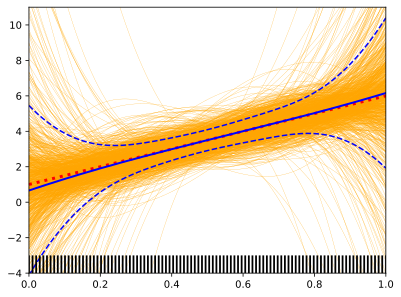

In [44]:
import numpy as np
import scipy.stats as ss
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge


# X живет на интервале [0, 1] и имеет бета-распределение
# Параметры a и b отвечают за форму распределения X:
# - чем больше a, тем меньше плотность в районе нуля,
# - чем больше b, тем меньше плотность в районе единицы.
# Случай a = b = 1 соответствует распределению ss.uniform()


def f_(x):
    # Значение матожидания Y, если известно, что X = x
    return 1 + 5 * x

#a, b = 1, 1
#seed = 1337
#n_obs = 10  # количество наблюдений в тренировочном датасете
#alpha = 0  # степень регуляризации

def main(a = 1, b = 1, seed = 1337, n_obs = 10, alpha = 0, f = f_, n_reps=1000):
    x_dist = ss.beta(a, b)
    def generate(n):
        # Истинная модель имеет вид Y|(X=x) = f(x) + eps, eps ~ N(0, 1)
        x = x_dist.rvs(size=n).reshape(-1, 1)
        y = f(x) + ss.norm.rvs(size=n).reshape(-1, 1)
        return x, y

    def model(alpha):
        # Обучаемая модель (т.е. y = f*(x, beta) + eps) представляет собой полиномиальную
        # регрессию третьй степени: y = a + bx + cx^3 + dx^3 + eps
        # beta* ищется с помощью ридж-регрессии с параметром регуляризации alpha,
        # случай alpha = 0 соответствует обычному МНК
        # Перед тем, как попасть в модель, факторы нормализуются
        return Pipeline([('PolyFeatures', PolynomialFeatures(3)),
                         ('Scaler', StandardScaler()),
                         ('Ridge', Ridge(alpha))])


    #n_reps = 1000  # количество итераций М-К
    x = np.linspace(0, 1, 1000)
    pred = np.zeros((n_reps, len(x)))
    np.random.seed(seed) # фиксируем seed для воспроизводимости
    means = []
    for i in tqdm(range(n_reps)):
        # Обучаем модель на очередном датасете и предсказываем ее значения
        # на точках от 0 до 1
        gen = generate(n_obs)
        means.append(gen[0].mean())
        pred[i] = model(alpha).fit(*gen).predict(x.reshape(-1, 1)).ravel()
    #print(f"MEAN: {np.array(means).mean()}")
    #print(f"{np.array(means).var()}")


    print(f'E(bias²(X)) ≈ {((f(x) - pred.mean(axis=0)) ** 2 * x_dist.pdf(x)).sum() / x_dist.pdf(x).sum():.4f}')
    #print(f'VAR {pred.var(axis=0).mean()}, MAX {max(pred.var(axis=0))}, MED {np.median(pred.var(axis=0))}')
    print(f'E(variance(X)) ≈ {(pred.var(axis=0) * x_dist.pdf(x)).sum() / x_dist.pdf(x).sum():.4f}')

    # Рисуем кучу кривых, соответствующих разным обучающим датасетам
    line_segments = LineCollection([np.vstack([x, pred[i]]).T for i in range(n_reps)], linewidths=0.2,
                                   colors='orange', linestyle='solid')
    plt.gca().add_collection(line_segments)

    # Рисуем f(x), E(f*(x, beta*)) и E(f*(x, beta*)) +/- sqrt(variance(x))
    plt.plot(x, f(x), color='red', linestyle='dotted', linewidth=3)
    plt.plot(x, pred.mean(axis=0), color='blue', linewidth=2)
    plt.plot(x, pred.mean(axis=0) + pred.std(axis=0), color='blue', linestyle='dashed', linewidth=1.5)
    plt.plot(x, pred.mean(axis=0) - pred.std(axis=0), color='blue', linestyle='dashed', linewidth=1.5)

    # Рисуем плотность распределения X в виде barplota
    # (barplot выбран чисто для красоты, мне кажется так лучше, чем просто график плотности)
    bars = np.linspace(0, 1, 100)
    plt.bar(bars, x_dist.pdf(bars), width=0.5/100, bottom=-4, color='black', zorder=10)

    plt.xlim([0, 1])
    plt.ylim([-4, 11])
    plt.show()

main()

**1**

Что изменяется - резко увеличивается дисперсия(правый хвост улетает намного раньше)
Из модели можно заметить, что дисперсия от выборки зависит только через $pred.var(axis=0)$, то есть похоже из-за маленького размера выборки(n_obs) редкие события сильно влияют на дисперсию в выборке(то есть характеристики выборки очень зависят от рандома), поэтому в целом дисперсия может сильно возрасти. С увеличением размера выборки зависимость от рандома у каждой из выборок сильно уменишается.

**2**

наше распределение с очень большой вероятностью 1, и очень редко 0 (вероятность возрастает от 0 к 1), поэтому точки левее 0.4 (ss.beta(5, 1).cdf(0.4) = 0.01) очень очень редки и являются выбросами, и наша модель не сильно ориентируется на них(то есть модель обучается на точках с ~[0.4-1.0])

**3**

вероятность выбросов(отклонений) очень мала, а мы считаем взвешенную оценку

**4**

по 30 точкам модель хорошо(намного лучше, чем по 10) приближает истину: средние значения и так были хорошие, но стали еще лучше, а дисперсия уменьшилась значительно

**5**

Благодаря ридж регрессии у нас сильно улучшились предсказания - стали более пологими. Из-за этого сильно уменишились матожидания ошибки и дисперсии.

**6**

из-за большой alpha нам дорого ставить большие коэффициенты, поэтому var уменьшается, но при этом страдает предсказание и bias растет
получается даже так, что при x $\sim$ 0 дисперсия меньше, чем смещение



**7**

при $alpha \rightarrow \infty$ регрессии становится слишком дорого ставить коэффициенты , поэтому у нас остается только константа, $min \text{ } E(Y - \beta_0^*)^2 \Rightarrow \beta_0^* = EY = \frac{\sum 5X_i + 1 + \epsilon}{n} $
$$\beta^* = (EY, 0, 0, 0) \Rightarrow E\beta^* = E [\frac{\sum 5X_i + 1 + \epsilon}{n}] = E[5X + 1]$$
$$f(x) = 5x + 1$$
$$bias^2(z) = (f(z) - (1, z, z^2, z^3)E\beta^*)^2 = (5z + 1 - E[5X + 1])^2$$
$$E [bias^2] = D[5X + 1] = 25/12 \sim 2.08$$

$$var^2 = D[(1, x, x^2, x^3)\beta^*] = D[\frac{\sum 5X_i + 1 + \epsilon}{n}] = \frac{25D[x] + D[\epsilon]}{n} \sim \frac{2.08 + 1}{10} = 0.308$$
$$E[var^2] = 0.308$$


**8**

при разных a и b у нас разные распределения x:

   при (a, b) = (6, 2) [(2, 6) - аналогично] мы переобучаемся на отрезок (0, 0.5) [0.5, 1], так как плотность x там намного выше и соответственно намного больше x будут там
   
   при a = b = 4 x распределен примерно нормально, и модель пытается обучиться на ступеньку - сгладить её
    
    

**9**


**10**
$$sin(x) = x - \frac{x^3}{6} + o(x^5)$$
$$\text{на } [0, \pi] \text{ } sin \text{ ведет себя очень похоже на многочлен}$$

$$ \text{из ряда тейлора и того, что } x\in[0, 1] \text{ видно, что ошибка апроксимации синуса мала}$$